In this notebook, we train the ODESolver model on the SEIR equation:

$$x'=\sigma (y-x)$$
$$y'=x(\rho-z)-y$$
$$z'=xy-\beta z$$
The parameters we're estimating are: $\sigma, \rho, \beta$

In [1]:
import sys
import torch

try:
    from torchts.nn.models.ode import ODESolver
    from torchts.utils.data import generate_ode_dataset
except:
    sys.path.append("../../../")
    from torchts.nn.models.ode import ODESolver
    from torchts.utils.data import generate_ode_dataset

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [2]:
# Lorenz 63 equations
def x_prime(prev_val, coeffs):
    return coeffs["sigma"]*(prev_val["y"]-prev_val["x"])

def y_prime(prev_val, coeffs):
    return prev_val["x"]*(coeffs["rho"]-prev_val["z"])-prev_val["y"]

def z_prime(prev_val, coeffs):
    return prev_val["x"]*prev_val["y"]-coeffs["beta"]*prev_val["z"]

ode = {"x": x_prime, "y": y_prime, "z": z_prime}

# Initial conditions [1,0,0]
ode_init = {"x":1, "y":0, "z":0}

# Constants (Parameters)
ode_coeffs = {"sigma": 10., "rho": 28., "beta": 2.7}


# 4th Order Runge-Kutta - Data Generation for nt = 1000

In [3]:
ode_solver = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_coeffs,
    dt=0.01,
    solver="rk4",
    optimizer=None,
)

result = ode_solver(1000)

In [4]:
result

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 9.1793e-01,  2.6634e-01,  1.2636e-03],
        [ 8.6792e-01,  5.1173e-01,  4.6540e-03],
        ...,
        [-5.6997e+00, -5.8341e+00,  2.3410e+01],
        [-5.7226e+00, -6.0452e+00,  2.3121e+01],
        [-5.7641e+00, -6.2715e+00,  2.2854e+01]], grad_fn=<StackBackward>)

<ipython-input-5-97482dcfaca7>:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


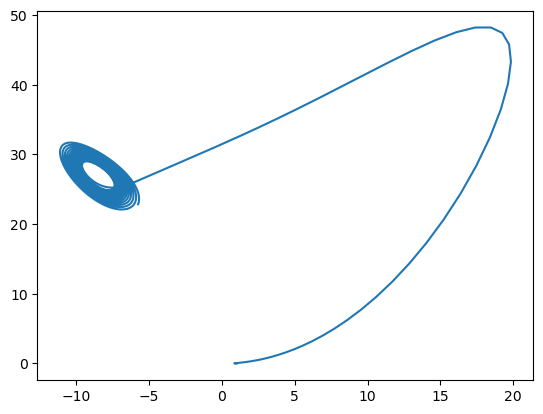

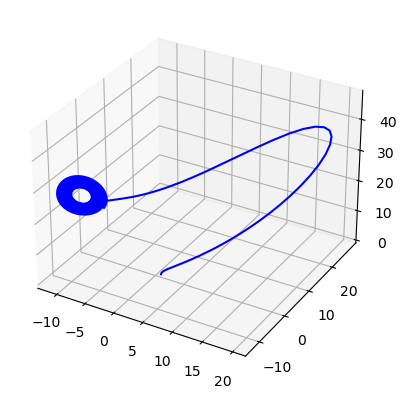

In [5]:
result_np = result.detach().numpy() # Convert to numpy array

# 2D plot of X and Z
plt.plot(result_np[:,0], result_np[:,2])

# 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot3D(result_np[:,0], result_np[:,1], result_np[:,2], 'blue')

plt.show()

# Runge-Kutta method for training

In [26]:
ode_train_coeffs = {"sigma": 20*torch.rand(()), "rho": 20*torch.rand(()), "beta": 20*torch.rand(())} # Start with arbitrary values

ode_solver_train = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_train_coeffs,
    dt=0.01,
    solver="rk4",
    optimizer=torch.optim.Adam,
    optimizer_args={"lr": 0.5},
    scheduler=torch.optim.lr_scheduler.MultiStepLR,
    scheduler_args={"milestones": [5],"gamma": 0.2}
)

/Users/marty/Documents/GitHub/torchTS/examples/ode/lorenz63/../../../torchts/nn/models/ode.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_parameter(name, nn.Parameter(torch.tensor(value)))


In [27]:
result_x, result_y = generate_ode_dataset(result)

In [28]:
ode_solver_train.fit(
    result_x, result_y, max_epochs=10, batch_size=64
)

Epoch: 0	 Loss: tensor(2.0966, grad_fn=<MseLossBackward>)
{'sigma': Parameter containing:
tensor(8.7229, requires_grad=True), 'rho': Parameter containing:
tensor(24.2090, requires_grad=True), 'beta': Parameter containing:
tensor(11.4539, requires_grad=True)}
Epoch: 1	 Loss: tensor(0.1969, grad_fn=<MseLossBackward>)
{'sigma': Parameter containing:
tensor(10.0319, requires_grad=True), 'rho': Parameter containing:
tensor(28.6867, requires_grad=True), 'beta': Parameter containing:
tensor(5.1467, requires_grad=True)}
Epoch: 2	 Loss: tensor(0.0098, grad_fn=<MseLossBackward>)
{'sigma': Parameter containing:
tensor(10.4058, requires_grad=True), 'rho': Parameter containing:
tensor(28.8981, requires_grad=True), 'beta': Parameter containing:
tensor(2.0820, requires_grad=True)}
Epoch: 3	 Loss: tensor(0.0149, grad_fn=<MseLossBackward>)
{'sigma': Parameter containing:
tensor(10.1831, requires_grad=True), 'rho': Parameter containing:
tensor(27.9034, requires_grad=True), 'beta': Parameter containing:


In [29]:
ode_solver_train.coeffs

{'sigma': Parameter containing:
 tensor(9.9901, requires_grad=True),
 'rho': Parameter containing:
 tensor(28.0002, requires_grad=True),
 'beta': Parameter containing:
 tensor(2.7044, requires_grad=True)}

# Predictions for nt = 10000

In [30]:
results_test = ode_solver_train(10000)

In [31]:
results_test

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 9.1801e-01,  2.6635e-01,  1.2637e-03],
        [ 8.6804e-01,  5.1178e-01,  4.6547e-03],
        ...,
        [-1.0137e+01, -1.6682e+01,  1.8525e+01],
        [-1.0797e+01, -1.7438e+01,  1.9794e+01],
        [-1.1461e+01, -1.8094e+01,  2.1218e+01]], grad_fn=<StackBackward>)

<ipython-input-32-daf29898cee0>:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


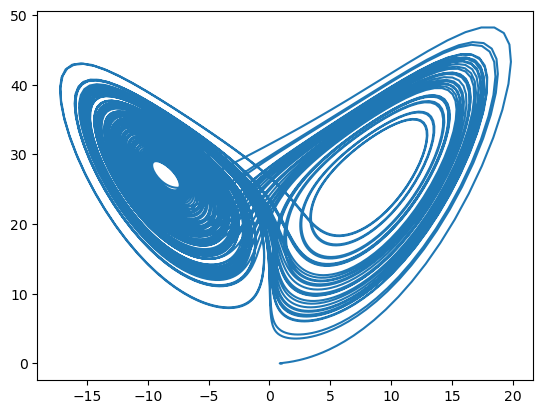

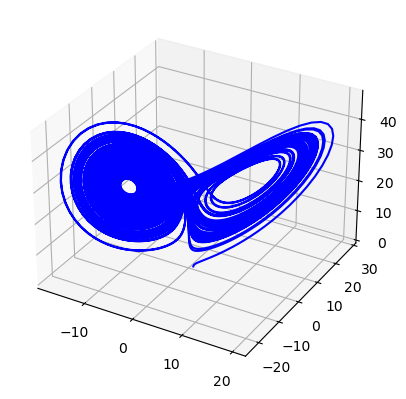

In [32]:
results_test_np = results_test.detach().numpy() # Convert to numpy array

# 2D plot of X and Z
plt.plot(results_test_np[:,0], results_test_np[:,2])

# 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot3D(results_test_np[:,0], results_test_np[:,1], results_test_np[:,2], 'blue')

plt.show()

# Mean Squared Error Loss - Train set (nt = 1000)

In [33]:
ode_solver = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs={"sigma": 10., "rho": 28., "beta": 2.7},
    dt=0.01,
    solver="rk4",
    optimizer=None,
)

In [34]:
loss = torch.nn.MSELoss()
loss(ode_solver(1000),ode_solver_train(1000))

tensor(0.0041, grad_fn=<MseLossBackward>)

# Mean Squared Error Loss - (nt = 2000)

In [35]:
loss = torch.nn.MSELoss()
loss(ode_solver(2000),ode_solver_train(2000))

tensor(15.9060, grad_fn=<MseLossBackward>)